# Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [3]:
data = pd.read_csv('complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

In [4]:
data = data[["Product","Consumer complaint narrative"]]

In [5]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Mortgage,NaN
2,Mortgage,NaN
3,Mortgage,NaN
4,"Credit reporting, credit repair services, or o...",NaN


In [6]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1377550
Debt collection                                                                  448757
Mortgage                                                                         363773
Credit card or prepaid card                                                      162359
Credit reporting                                                                 140430
Checking or savings account                                                      139122
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      70632
Money transfer, virtual currency, or money service                                46653
Vehicle loan or lease                                                             36481
Consumer Loan                   

In [7]:
data.dropna(axis = 0, inplace = True)

In [8]:
data.head()

,Product,Consumer complaint narrative
114,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I bought a car from XXXX XXXX. ..."
118,Credit card or prepaid card,"On XX/XX/22, I submitted a dispute to my credi..."
158,Debt collection,IM A VICTIM OF IDENTITY THEFT I am writing in ...
163,Debt collection,I paid my individual portion prior to XXXX in ...
245,Mortgage,As the executor of my mother 's estate I sold ...


In [9]:
data.shape

(1087560, 2)

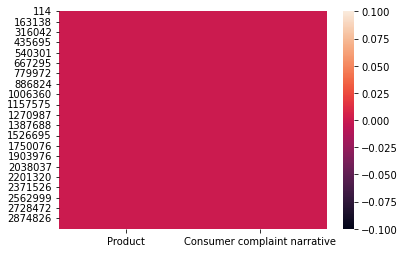

In [10]:
sns.heatmap(data.isnull())
plt.show()

Let's take a sample from this data :

In [11]:
data = data.sample(n = 20000)
data.head()

,Product,Consumer complaint narrative
2073193,"Credit reporting, credit repair services, or o...",I have tried to get the bank issuing a credit ...
1161608,Credit reporting,XXXX XXXX account is incorrectly reporting in ...
1960855,Mortgage,My wife and I were rolling my current mortgage...
1252073,"Payday loan, title loan, or personal loan",I received an online loan in the amount of {$1...
2311933,"Credit reporting, credit repair services, or o...",This is my 4th time disputing these accounts a...


In [12]:
data.shape

(20000, 2)

In [13]:
data = data.reset_index(drop = True)
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I have tried to get the bank issuing a credit ...
1,Credit reporting,XXXX XXXX account is incorrectly reporting in ...
2,Mortgage,My wife and I were rolling my current mortgage...
3,"Payday loan, title loan, or personal loan",I received an online loan in the amount of {$1...
4,"Credit reporting, credit repair services, or o...",This is my 4th time disputing these accounts a...


# Preprocessing & Vizz

In [14]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [15]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    9653
Debt collection                                                                 3482
Credit card or prepaid card                                                     1838
Mortgage                                                                        1831
Checking or savings account                                                      979
Student loan                                                                     623
Money transfer, virtual currency, or money service                               470
Vehicle loan or lease                                                            371
Payday loan, title loan, or personal loan                                        265
Bank account or service                                                          240
Consumer Loan                                                                    179
Money transfers                                                  

In [16]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Money transfers', 'Product'] = 'Money transfer, virtual currency, or money service'
# We will not consider other financial service

data = data[data.Product != 'Other financial service']


In [17]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    9653
Debt collection                                                                 3482
Credit card or prepaid card                                                     1838
Mortgage                                                                        1831
Checking or savings account                                                      979
Student loan                                                                     623
Money transfer, virtual currency, or money service                               502
Vehicle loan or lease                                                            371
Payday loan, title loan, or personal loan                                        265
Name: Product, dtype: int64

In [18]:
data = data.reset_index(drop=True)

In [19]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",I have tried to get the bank issuing a credit ...
1,"Credit reporting, credit repair services, or o...",XXXX XXXX account is incorrectly reporting in ...
2,Mortgage,My wife and I were rolling my current mortgage...
3,"Payday loan, title loan, or personal loan",I received an online loan in the amount of {$1...
4,"Credit reporting, credit repair services, or o...",This is my 4th time disputing these accounts a...
...,...,...
19539,"Credit reporting, credit repair services, or o...",I was made aware of an attempt to pull my cred...
19540,Debt collection,A collection appeared on my report on XX/XX/20...
19541,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
19542,"Money transfer, virtual currency, or money ser...",On XX/XX/2021 I XXXX XXXX contacted Chime via ...


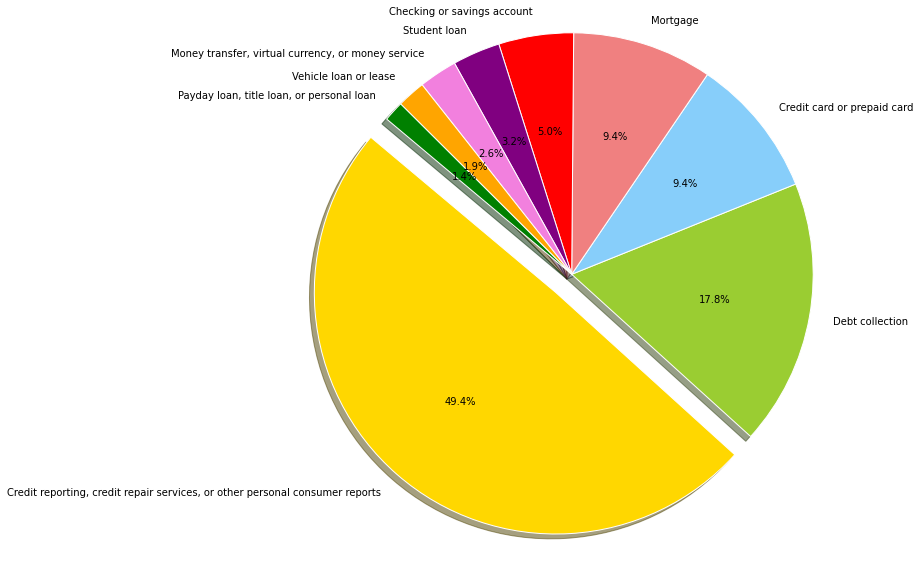

In [20]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [21]:
def complaint_product(indx,data):
    complaint = data['Consumer complaint narrative'][indx]
    product = data['Product'][indx]
    print(complaint)
    print('------------------------------')
    print("Product : ",product)

In [22]:
complaint_product(238, data)

I am attempting to work with my student loan lender. I do, however, wish everything to be in writing that I can save for my own resources. I have difficulty understanding speech over a telephone, in addition to being afraid to speak through one. I would not be able to fully understand what is being said to me through a phone, and I fear I will agree to something that will not sufficiently help my case. I suffer from XXXX and XXXX that affects my health for days after a phone call. Although I have explained this through email to the company, they have stated that they can not work with my case through email or mail. The only communication I 've received is in the form of a telephone number. I have also received threats against my paycheck in the form of garnishments and my tax return. I have attempted to make payments where and when I can, but my current bills already exceed my pay by XXXX dollars. I receive help from my parents for some of my bills. My daughter is XXXX and needs more c

In [23]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [24]:
# Code Here
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(clean_text) # apply clean_text function 

In [25]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",tried get bank issuing credit card correct err...
1,"Credit reporting, credit repair services, or o...",account incorrectly reporting name attached ap...
2,Mortgage,wife rolling current mortgage seterus inc line...
3,"Payday loan, title loan, or personal loan",received online loan amount make bi weekly pay...
4,"Credit reporting, credit repair services, or o...",time disputing accounts one responding cpfb su...
...,...,...
19539,"Credit reporting, credit repair services, or o...",made aware attempt pull credit unknown source ...
19540,Debt collection,collection appeared report demanding owe sure ...
19541,"Credit reporting, credit repair services, or o...",accordance fair credit reporting act violated ...
19542,"Money transfer, virtual currency, or money ser...",contacted chime via smart phone requested chec...


In [26]:
# After cleaning
complaint_product(238, data)

attempting work student loan lender however wish everything writing save resources difficulty understanding speech telephone addition afraid speak one would able fully understand said phone fear agree something sufficiently help case suffer affects health days phone call although eplained email company stated work case email mail communication received form telephone number also received threats paycheck form garnishments ta return attempted make payments current bills already eceed pay dollars receive help parents bills daughter needs care able find elsewhere work sleeps nights week leaves night schedule must reverse school week take care reverse job well also received notice legal service state could assist refuses assist discharging private student loans end rope little choice proceed
------------------------------
Product :  Student loan


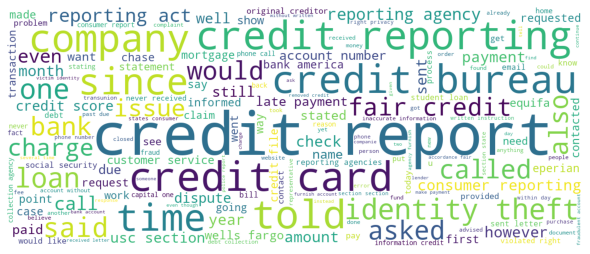

In [28]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [29]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

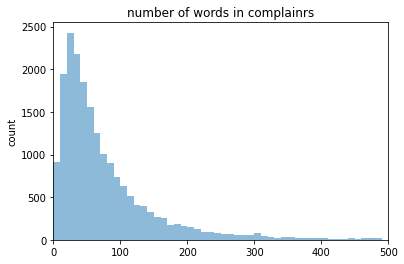

In [30]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

<AxesSubplot:>

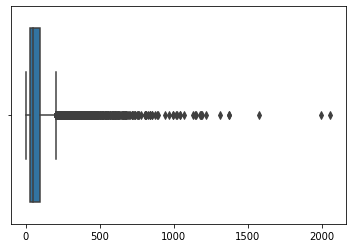

In [31]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26935 unique tokens.


In [33]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (19544, 250)


In [34]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (19544, 9)


In [35]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(15635, 250) (15635, 9)
(3909, 250) (3909, 9)


In [36]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=None))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
220/220 [==============================] - 170s 766ms/step - loss: 1.2693 - accuracy: 0.5621 - val_loss: 1.0278 - val_accuracy: 0.6407
Epoch 2/5
220/220 [==============================] - 206s 935ms/step - loss: 0.8672 - accuracy: 0.7210 - val_loss: 0.9002 - val_accuracy: 0.7244
Epoch 3/5
220/220 [==============================] - 181s 823ms/step - loss: 0.6636 - accuracy: 0.7896 - val_loss: 0.9190 - val_accuracy: 0.7270
Epoch 4/5
220/220 [==============================] - 181s 821ms/step - loss: 0.5781 - accuracy: 0.8164 - val_loss: 0.8189 - val_accuracy: 0.7442
Epoch 5/5
220/220 [==============================] - 183s 833ms/step - loss: 0.4681 - accuracy: 0.8530 - val_loss: 0.7714 - val_accuracy: 0.7660


In [38]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

123/123 [==============================] - 8s 63ms/step - loss: 0.7348 - accuracy: 0.7777
Test set
  Loss: 0.73
  Accuracy: 0.78


In [39]:
Y_pred = model.predict(X_test)

123/123 [==============================] - 7s 55ms/step


In [40]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [46]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

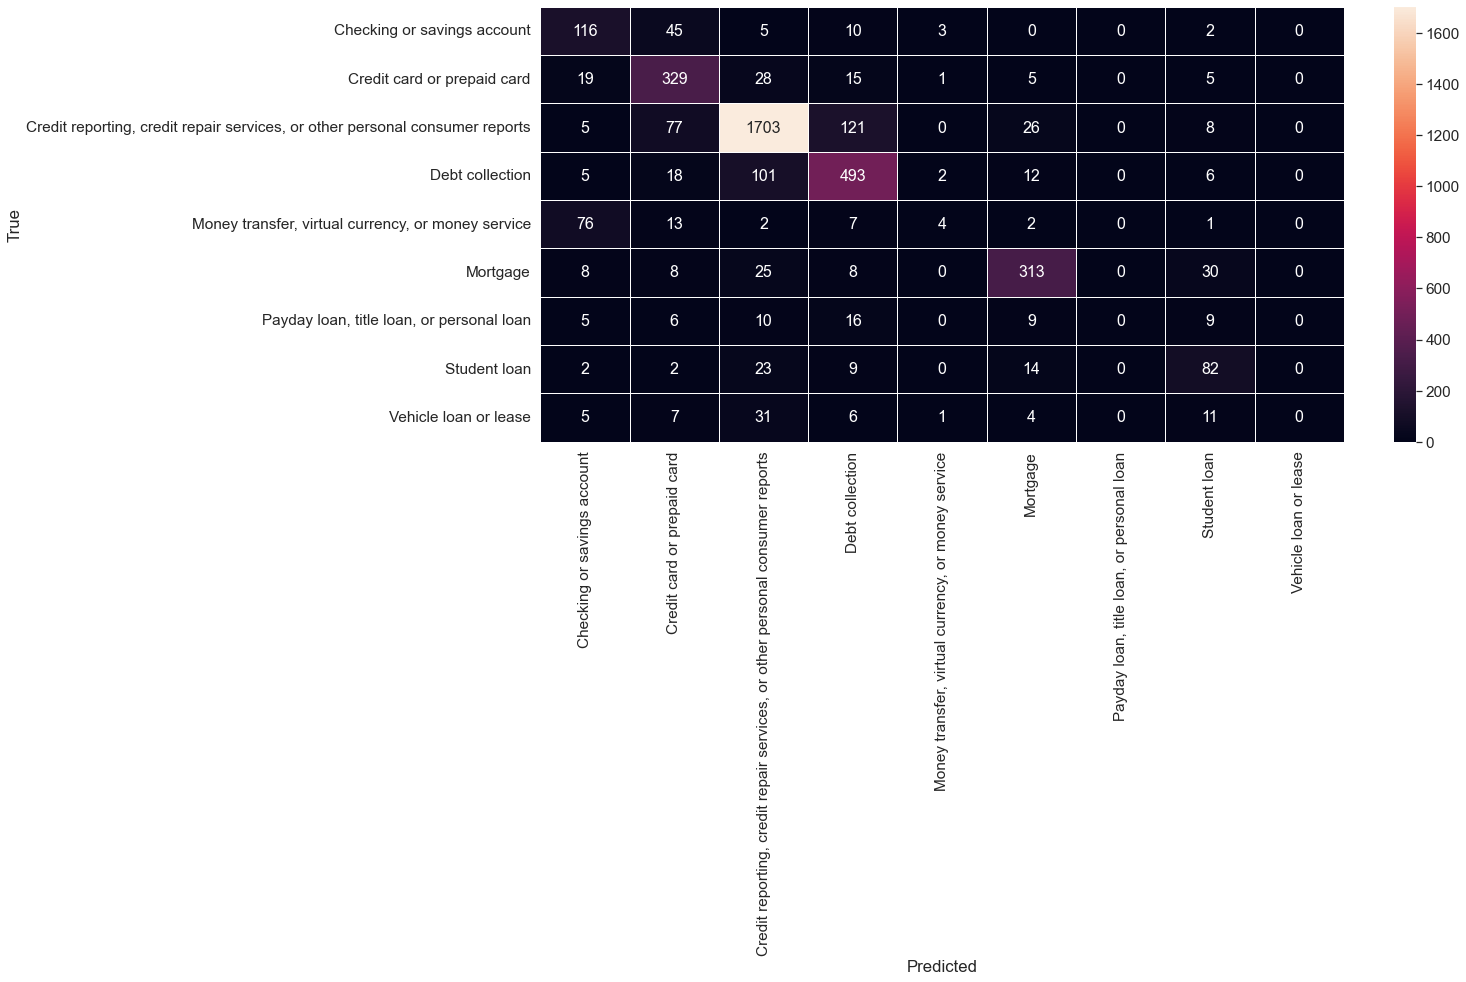

In [47]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()